In [43]:
import os
import math

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
##########################################################################################################

def filterinitialset (filename, headername = "vibrational level v\Temperature(K)",  \
    factor = 1.0, normalize = False):

    dfin = pd.read_excel(filename)

    #print(dfin)
    
    dfdict = {}
    
    tempvalues = list(dfin.columns[1:])
    vibvalues = list(dfin[headername].values)

    min = float("inf")
    max = float("-inf")
    for c in dfin.columns:
        dfdict[c] = []
        if c == headername:
            dfdict[c] = list(dfin[c].values)
        else:
            for v in dfin[c].values:
                val = factor*v
                if val > max:
                    max = val
                if val < min:
                    min = val

    for c in dfin.columns:
        if c != headername:
            for v in dfin[c].values:
                val = factor*v
                valp = (val - min) / (max - min)
                if normalize:
                    dfdict[c].append(valp)
                else:
                    dfdict[c].append(val)

    df = pd.DataFrame.from_dict(dfdict)

    return df, vibvalues, tempvalues

##############################################################################

def plotfull3dcurve (df, vib_values, temp_values):

    y = []
    x = []
    for t in temp_values:
        for idx in range(len(vib_values)):
            x.append([float(t), float(vib_values[idx])])
            y.append(df[t].values[idx])

    X = np.array(x)
    Y = np.array(y)

    xdim = len(temp_values)
    ydim = len(vib_values)

    Xp = np.zeros((xdim, ydim), dtype=float)
    Yp = np.zeros((xdim, ydim), dtype=float)
    Zp = np.zeros((xdim, ydim), dtype=float)
    for xidx in range(xdim):
        t = temp_values[xidx]
        for yidx in range(ydim):
            v =  vib_values[yidx]
            Xp[xidx, yidx] = float(t)
            Yp[xidx, yidx] = float(v)
            Zp[xidx, yidx] = df[t].values[yidx]

    #fig = plt.figure(figsize=(10,8))
    fig = plt.figure(figsize=plt.figaspect(2.))
    plt.gcf().set_size_inches(40, 30)
    ax = fig.add_subplot(2,1,1, projection='3d')
    surf = ax.plot_surface(Xp, Yp, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
    plt.show()

##########################################################################################################3

def fitusingscikitl (train_x, train_y):
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-5, 1e5))* gp.kernels.RBF(length_scale=1)
    kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF([5,5], (1e-2, 1e2))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, \
        normalize_y=False)
    print("Start training ")
    model.fit(train_x, train_y)
    print("Done ")

    return model

##########################################################################################################

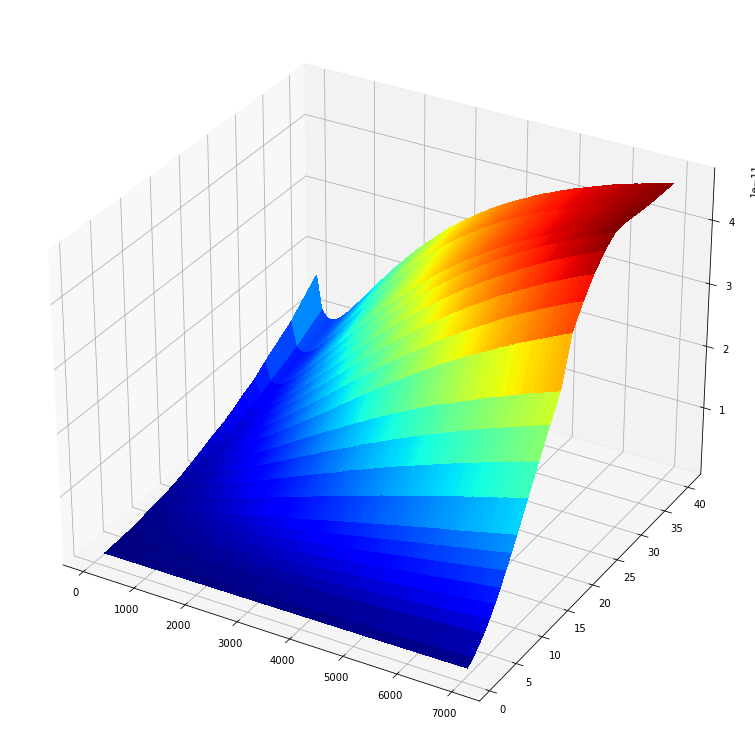

In [45]:
filename = "N2N2_dataset.xls"
df, vib_values , temp_values = filterinitialset (filename)
plotfull3dcurve (df, vib_values, temp_values)

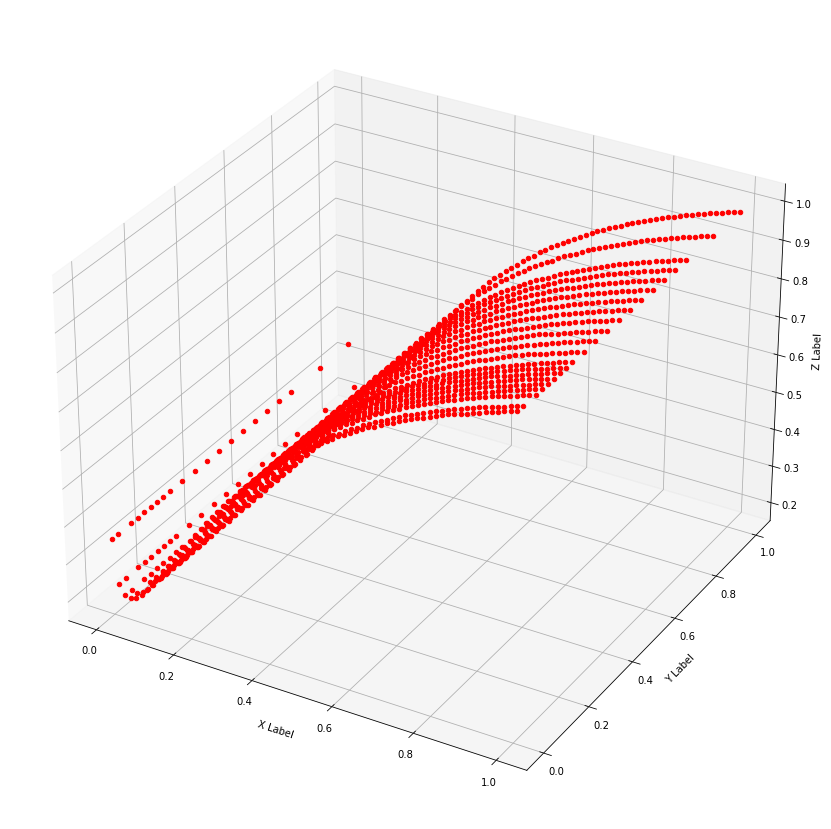

Start training 


KeyboardInterrupt: 

In [46]:
maxt = max(temp_values)
mint = min(temp_values)

minv = min(vib_values)
maxv = max(vib_values)

train_xy = []
train_z = []

maxz = float("-inf")
minz = float("+inf")

for tidx, t in enumerate(temp_values):
    for vidx, v in enumerate(vib_values):
        zval = df[t].values[vidx]

        if zval < minz:
            minz = zval
        elif zval > maxz:
            maxz = zval

for tidx, t in enumerate(temp_values):
    tnorm = (t - mint)/(maxt - mint)
    for vibidx, v in enumerate(vib_values):
        vnorm  = (v - minv)/(maxv - minv)    
        train_xy.append([tnorm, vnorm])
        
        zval = df[t].values[vidx]
        train_z.append((zval - minz)/(maxz - minz))

train_xy = np.asarray(train_xy)
train_z = np.asarray(train_z)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    ax.scatter(x, y, z, marker="o", color="r")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.gcf().set_size_inches(20, 15)

plt.show()

model = fitusingscikitl (train_xy, train_z)

test_xy = []
for t in np.linspace(0.0, 1.0, 150):
    for v in np.linspace(0.0, 1.0, 150):
        train_xy.append([t, v])

test_xy = np.asarray(test_xy)
z_pred, std = model.predict(test_xy, return_std=True)
